# Machine Learning in Python - Project 2


* Kyriacos Xanthos
* Lorenzo Wagemaker
* Harris Abdul Majid
* Ed Shakespeare

##  Setup

Before we start analysing the data the following packages have to be imported:

In [ ]:
# Install required packages
!pip install -q -r requirements.txt

In [ ]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

# Needed for fitting model
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_precision_recall_curve 
from sklearn.preprocessing import LabelEncoder
import copy


## Introduction

Every hotel has to deal with cancellations - a significant problem when deciding on how many rooms to book and which overbooking techniques to apply. Cancellations lead to a loss of revenue due to empty rooms and lower rates in an attempt to book their rooms. To deal with cancellations, hotels can enforce a no-cancellation policy. Unfortunately, without cancellations, guests might choose to stay at other nearby hotels. Thanks to Data Science, we can develop Machine Learning models that accurately predict cancellations and influence hotel booking strategies. 

In this report, we investigate why customers cancel their reservations and provide a model to predict cancellations. We will be using data collected by Antonio, Almedia and Nunes (2019) on hotel bookings. This large data set (over 100,000 data points) contains data for two hotels in Portugal; a Resort Hotel located in Faro and a City Hotel located in Lisbon. Some relevant features include when the booking was made, average daily rate arrival date and whether the guest has cancelled previous bookings.

It would be interesting to explore how weather affects cancellations, but this requires additional data. Using a historical weather API provided by the [National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/webservices/v2), we gathered daily precipitation and daily average temperature data for both cities. The weather data was clean with only a couple of missing entries. Also, we might expect a relationship between cancellations and holidays, so we have included holiday data.

During Exploratory Data Analysis, we visualise the data, look for correlations and experiment with feature combinations. Then, we prepare the data for Machine Learning algorithms by cleaning the data and handling text/categorical features. 

During the Model Fitting and Tuning section, we looked at various Machine Learning algorithms including Logistic Regression, Naive-Bayes Classifier and some Tree-Based Models. After tuning, the Random Forest Classifier Model performed the best, achieving an accuracy of 85%. We discuss our results further in the Discussion & Conclusions section. 

##  Exploratory Data Analysis and Feature Engineering

The data we are using for the analysis is included in the `hotel.csv` file which we import below. This is a large data set with more than 110,000 bookings which will prove very valuable when creating a Machine Learning Model. After some exploration of the data using visualisation tools we created the `data_clean` function which takes as argument our data set and it takes care of some errors in the dataset. It replaces all of the NaN values for `children`, `agent` and `company` with zeros and replaces a NaN value of a `country` as a string "Unknown". It also removes bookings that don't make intuitive sense, ie. a booking with zeros for all `adults` `children` and `babies`, or when the number of weekend and weekdays nights add up to zero. The function also removes some outliers which became apparent when we plotted a scatter plot for each variable. These included removing outliers for `adr`, `adults`, `lead_time`, `children`, `babies`, `required_car_parking_spaces`. We also look for duplicates in the dataset and remove any rows that are exactly identical because it is unlikely that bookings are identical, we believe this was probably an error when gathering the information from the hotels.  

The total cleaning of this data amounted to removing about 35,000 entries out of the ~120,000 dataset. This means that we are left with around 85,000 bookings which will prove to be more than enough to create an accurate and reliable model.

In [ ]:
def data_clean(data):
    """
    Function that cleans the data from rows that do not make sense, from outliers and 
    from duplicate entries.

    input: data (dataframe)
        dataframe to be cleaned

    output: d_clean (dataframe)
        clean dataframe
    """
    #dictionary with columns with NaN values and their replacements
    null_replacements = {'children': 0.0, 'country': 'Unknown', 'agent': 0, 'company': 0}
    d_clean = data.fillna(null_replacements)

    print('rows before {}'.format(len(d_clean.index)))
    
    #remove bookings that don't make sense 
    zero_guests = list(d_clean.loc[d_clean['adults'] + 
    d_clean['children'] + d_clean['babies'] == 0].index)
    d_clean = d_clean.drop(d_clean.index[zero_guests], axis=0)
    
    # Reset index
    d_clean = d_clean.reset_index(drop=True)
    zero_nights = list(d_clean.loc[d_clean['stays_in_weekend_nights'] 
    + d_clean['stays_in_week_nights']== 0].index)
    d_clean = d_clean.drop(d_clean.index[zero_nights], axis=0)
    
    #remove some outliers
    adr_outlier = list(d_clean.loc[(d_clean['adr'] > 1000) | (d_clean['adr'] == 0) ].index)
    adults_outlier = list(d_clean.loc[d_clean['adults'] > 30].index)
    lead_outlier = list(d_clean.loc[d_clean['lead_time'] > 400].index)
    children_outlier = list(d_clean.loc[d_clean['children'] > 6].index)
    babies_outlier = list(d_clean.loc[d_clean['babies'] > 6].index)
    parking_outlier = list(d_clean.loc[d_clean['required_car_parking_spaces'] > 6].index)
    
    d_clean = d_clean.drop(adr_outlier + adults_outlier + lead_outlier
                           +children_outlier + babies_outlier + parking_outlier, axis=0)

    
    # drop rows with identical bookings
    d_clean = d_clean.drop_duplicates()
    
    print('rows after {}'.format(len(d_clean.index)))
    
    return d_clean

In [ ]:
d = pd.read_csv("hotel_weather.csv")
d = d[d['PRCP'].notna()]
d = d[d['TAVG'].notna()]
d = d.reset_index(drop=True)
d_clean = data_clean(d)

rows before 118736
rows after 84573


It would be interesting to explore how weather affects cancellations, but this required additional data. By doing some research, we found out that the Resort Hotel was located in Faro and the City Hotel was located in Lisbon. Using a historical weather API provided from the [National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/webservices/v2), we gathered daily precipitation and daily average temperature data for both cities. The weather data was clean with only a couple of missing entries. 

Since we have a very large dataset, we decided to remove the ~600 rows with missing precipitation/average temperature entries. Another option would have been to impute the missing entries to mean.

We concated the relevant columns of this dataset (`PRCP` and `TAVG` which are precipitation and temperature average respectively) with the relevant date in the `hotel.csv` to create the new file that we use which we call `hotel_weather.csv`.

In an attempt to minimise the number of columns in our dataset, so that our model will not be too computationally expensive, we created the `feature_engineering` function which creates some new columns in our data to be used in our analysis. It creates a binary variable which determines if the room assigned was the same as the one reserved for a booking, another binary variable `net_canceled` which  is True when the previous cancelation of a guest are more than the non-canceled bookings, and another variable `is_holiday` determining if a booking was made on a particular holiday in Portugal. The holidays we include are New Year's Eve and the last weeks of August. 

In [ ]:
def feature_engineering(data):
    """
    Function that applies feature engineering to our dataset. Creates new columns to be used in our model.

    input: data (dataframe)
        dataframe without feature engineering

    output: d_clean (dataframe)
        feature engineered dataframe
    """
    # Make the new column which contains 1 if guest received the same room which was reserved otherwise 0
    data['Room'] = 0
    data.loc[ data['reserved_room_type'] == data['assigned_room_type'] , 'Room'] = 1
    
    # Checks if a customer has cancelled more bookings than than bookins not cancelled
    data['net_cancelled'] = 0
    data.loc[data['previous_cancellations'] > data['previous_bookings_not_canceled'] , 'net_cancelled'] = 1
    
    data['is_holiday'] = 0
    # New Year's Eve
    data.loc[data['arrival_date_week_number'] == 53, 'is_holiday'] = 1 
    # School summer holidays
    data.loc[(data['arrival_date_week_number'] >= 30) & 
    (data['arrival_date_week_number'] <= 34), 'is_holiday'] = 1

    return(data)

In [ ]:
d_clean = feature_engineering(d_clean)

Now that the data has been cleaned, it was possible to drop multiple columns as their data was either already included in the new features engineered or because their information was not relevant to the cancellation probability. For example, the `arrival_date_year` is not controllable by anyone, and all observations happened in the past, so this won't be relevant for the model. We remove `arrival_date_day_of_month` because this date should not have any effect on hotel bookings - weekends change day each month etc - as well as remove `arrival_date_month` since this is captured by week number. The other 4 features being removed have already been engineered into other features.

In [ ]:
def drop_feats(data):
    """
    Function that removes features that our data visualisations have shown are not important and
    also removes features that have been incorporated in the new rows after feature engineering.

    input: data (dataframe)
        dataframe without feature engineering

    output: data (dataframe)
        reduced column dataframe
    """
    data = data.drop(['arrival_date_year','arrival_date_day_of_month',
                            'arrival_date_month','assigned_room_type','reserved_room_type',
                            'previous_cancellations','previous_bookings_not_canceled'],axis=1)
    return data
d_clean = drop_feats(d_clean)

In [ ]:
d_clean = d_clean.drop(['DATE'], axis=1) # Drop duplicate date information

d_clean_untransformed = copy.copy(d_clean) # Keep a copy that doesn't get label encoded, for plots

Next, we needed to convert any categorical data into numerical data so that it can be interpreted by the classifiers that will be used. This is because models like decision trees or random forests cannot operate on `object` data types.  For this purpose, the transform function was defined that uses a label encoder to generate labels for each different type of each category. The label encoder used is one from the sklearn package known as `LabelEncoder`. This encoder gives each different category a value from 0 to (number of variables)-1. Then, when the categories are encoded as these integer values, any machine learning model can be fitted to the data.

In [ ]:
def transform(d_clean):
    """
    Function that transforms categorical data using a Label Encoder from sklearn.

    input: data (dataframe)
        dataframe with categorical data

    output: data (dataframe)
        dataframe with label encoding.
    """
    
    le = LabelEncoder()
    
    ## Select all categorcial features
    categorical_features = list(d_clean.columns[d_clean.dtypes == object])    
    
    ## Apply Label Encoding on all categorical features
    transformed = d_clean[categorical_features].apply(lambda x: le.fit_transform(x))
    d_clean.drop(['hotel', 'meal','country','market_segment'
    ,'distribution_channel','deposit_type','customer_type'], axis=1, inplace=True)
    return d_clean.join(transformed)

d_clean = transform(d_clean)

Now that the data has been cleaned and the categorical features have been labeled, it is possible to generate a correlation grid that will give the first glimpses of features that are correlated (note that lighter shades indicate the features are more correlated):

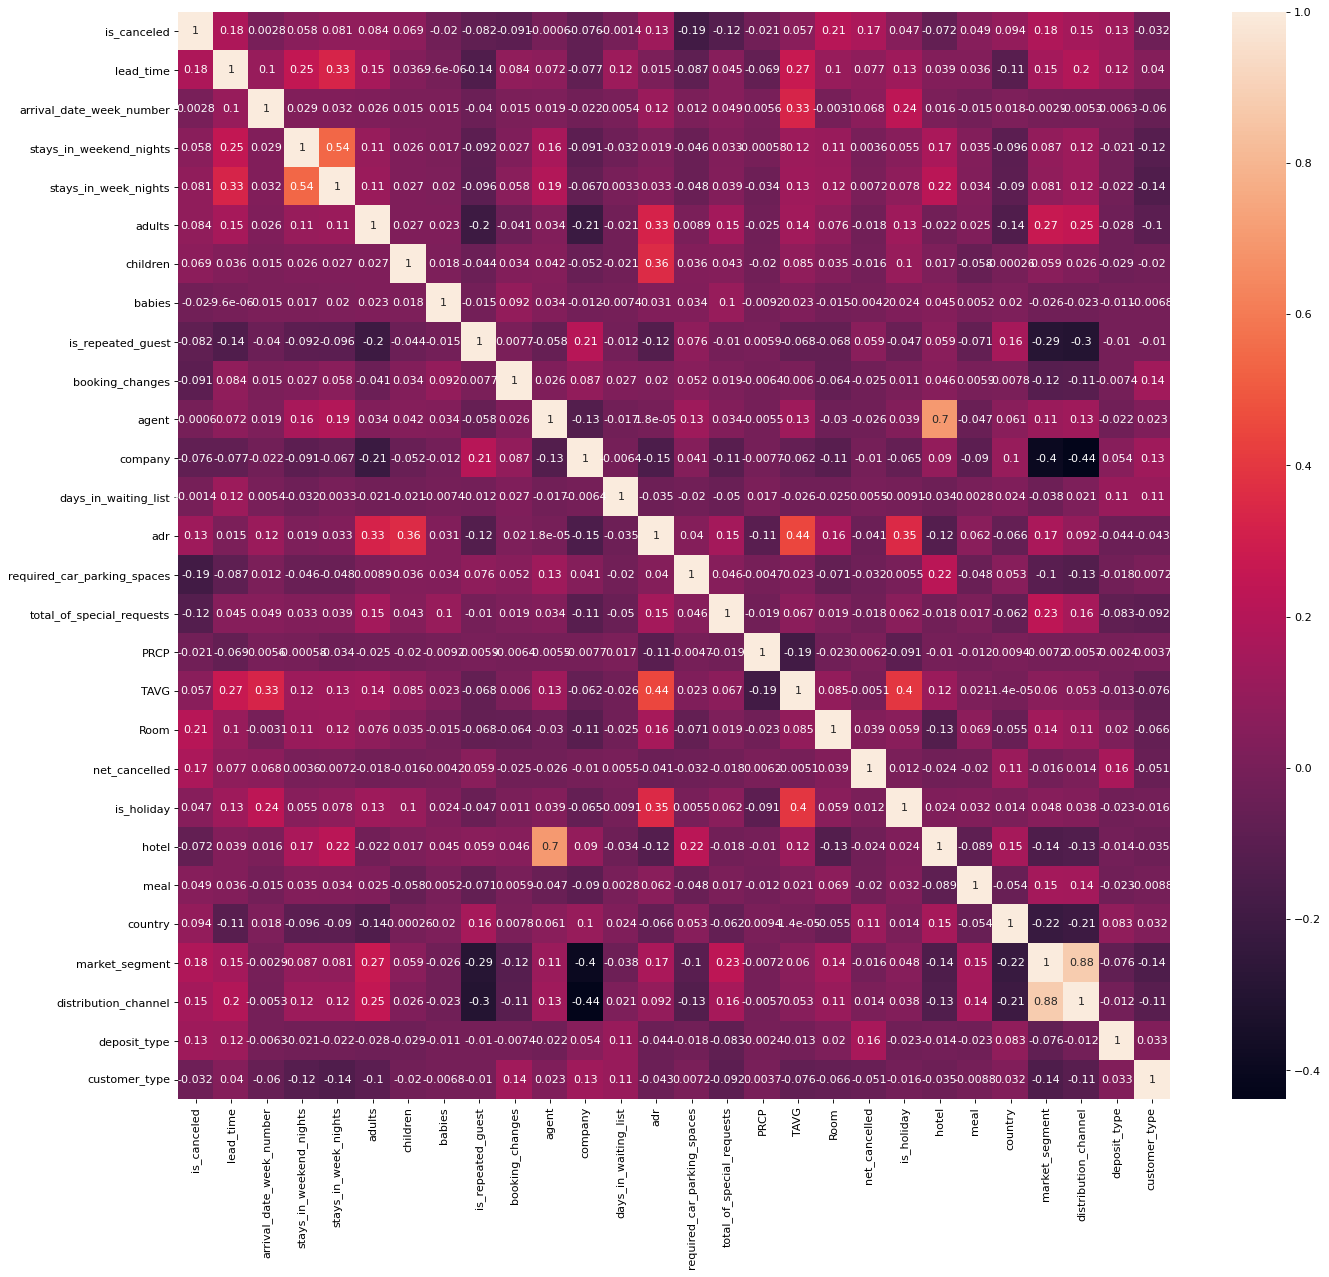

In [ ]:
# Plot the heatmap to see correlation with columns
fig, ax = plt.subplots(figsize=(20,18))
sns.heatmap(d_clean.corr(), annot=True, ax=ax);

Clearly `lead_time`, `deposit_type`, `total_of_special_requests`, `required_car_parking_spaces`, `distribution_channel`, `country` and `previous_cancellations` are most correlated with the `is_cancelled` feature. Now that we know what features correlate with `is_canceled` we present some useful visualisations that begin to show the relationships:

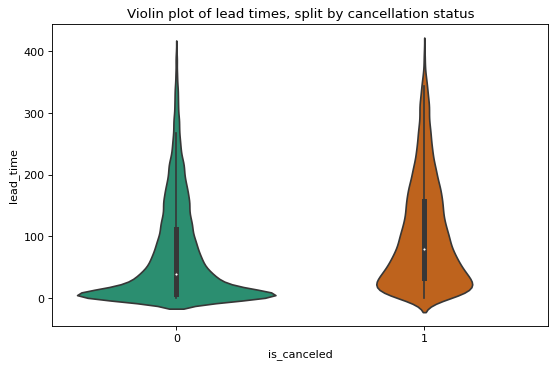

In [ ]:
sns.violinplot(y='lead_time', x='is_canceled', data=d_clean,palette='Dark2')
plt.title('Violin plot of lead times, split by cancellation status')
plt.show()


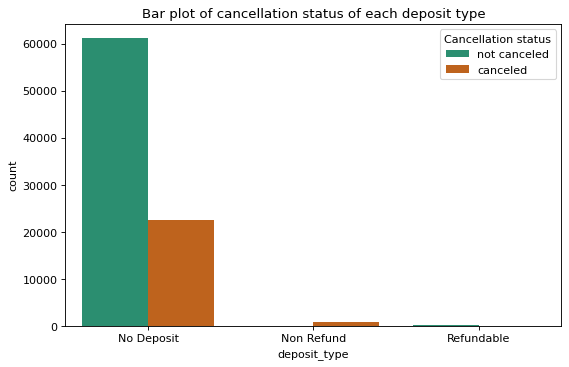

In [ ]:
sns.countplot(x='deposit_type', hue='is_canceled', 
data=d_clean_untransformed, palette='Dark2')

plt.legend(["not canceled", "canceled"],title = 'Cancellation status')
plt.title('Bar plot of cancellation status of each deposit type')
plt.show()


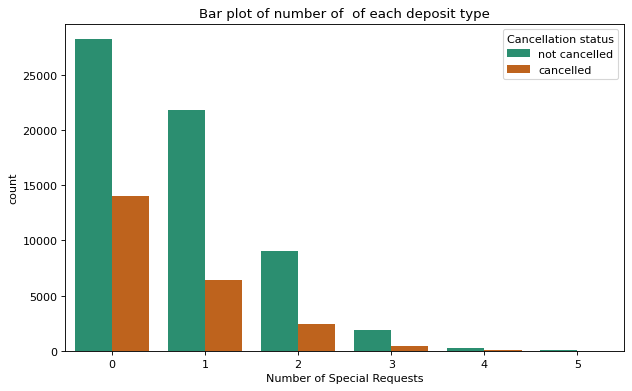

In [ ]:
# plot special requests according to cancellations
sns.countplot(x=d_clean["total_of_special_requests"], 
hue=d_clean["is_canceled"],palette='Dark2')

plt.xlabel("Number of Special Requests")
plt.legend(["not cancelled", "cancelled"],title = 'Cancellation status')
plt.title('Bar plot of number of  of each deposit type')
plt.tight_layout()
plt.show()

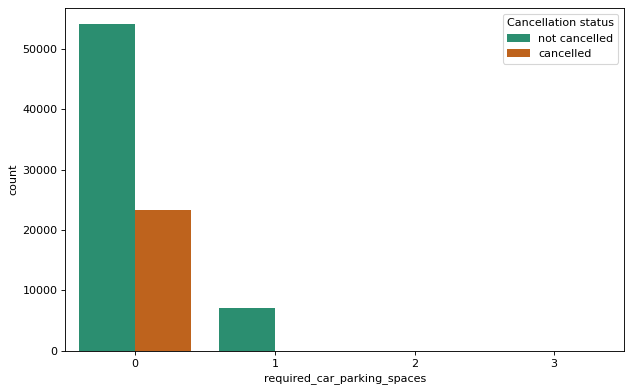

In [ ]:
# plot special requests according to cancellations
sns.countplot(x=d_clean["required_car_parking_spaces"], 
hue=d_clean["is_canceled"],palette='Dark2')

plt.xlabel("required_car_parking_spaces")
plt.legend(["not cancelled", "cancelled"],title = 'Cancellation status')
plt.tight_layout()
plt.show()

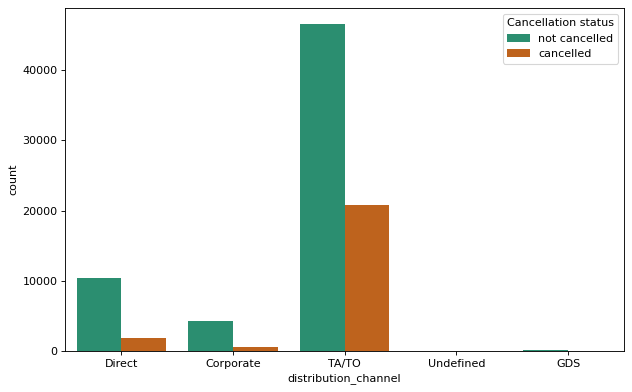

In [ ]:
# plot special requests according to distribution channel
sns.countplot(x=d_clean_untransformed["distribution_channel"], 
hue=d_clean_untransformed["is_canceled"],palette='Dark2')

plt.xlabel("distribution_channel")
plt.legend(["not cancelled", "cancelled"],title = 'Cancellation status')
plt.tight_layout()
plt.show()

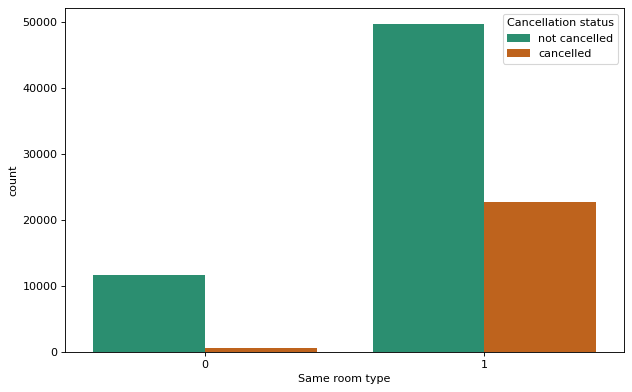

In [ ]:
sns.countplot(x='Room', hue='is_canceled', data=d_clean, palette='Dark2')
plt.xlabel('Same room type')
plt.legend(["not cancelled", "cancelled"],title = 'Cancellation status')
plt.tight_layout()
plt.show()


An interesting observation for the countplot differentiating `deposit_type`, is that it shows the opposite result of what one would expect. It seems that a lot more (order of ~1,000) Non-Refundable bookings were canceled than not canceled. An exploration as to why this is led us to the realisation that this was related with the VISA requirements of Protugal for guests arriving from a non-European country. In order to apply for a VISA, one has to have a confirmation of a Non-Refundable booking of a hotel [(as described here)](https://www.schengenvisainfo.com/schengen-visa-application-requirements/proof-accommodation/). This had a significant impact on the total cancelations of non-refundable rooms. 

Another interesting feature we had a look at was the `number_of_special_requests` feature. What stood out with this feature is that the proportion of cancellations seemed higher when the number of requests is lower. This makes intuitive sense as customers who have more demands are probably more serious about their reservations and thus less likely to cancel.

We also investigated the `required_car_parking_spaces`. This feature is of interest because reservations with higher numbers of required parking spaces seemed much less likely to cancel the reservation than reservations which did not need a parking space. This could possibly be due to fees that have to be paid when car parking spaces are reserved. This in effect creates an incentive not to cancel the reservation.

Another feature we looked into was the `distribution_channel` of the reservations. This feature was also useful in predicting cancellations as reservations stemming from the distribution channel labelled 3 seemed to have proportionally more cancelations than reservations from other channels.

With the feature engineering done before, the `room` feature seemed to have a particularly high correlation with cancellation status. This feature represented whether a reservation was assigned the room they reserved. Surpassingly, there is a much higher proportion of cancelations for reservations which were assigned the room they reserved than reservations that were assigned different rooms.

Below is a plot used to backup our decisions with regards to holiday dates. From the countplot of holidays by week number, there is a noticeable spike at the very end - week 53 - which is New Year's Eve. Therefore, we have included arrivals dated week 53 as 'holidays' in the data. There is also a peak around week 33, which is mid-August, which falls during the school holidays in Portugal, as well as in other countries. To be conservative, we will include weeks 30-34 as holidays, since this is the period from late July to late August and this will always be in the holiday, regardless of year [(week numbers)](https://www.epochconverter.com/weeks/2015) [(school holidays)](https://www.expatica.com/pt/education/children-education/school-holidays-in-portugal-69027/)

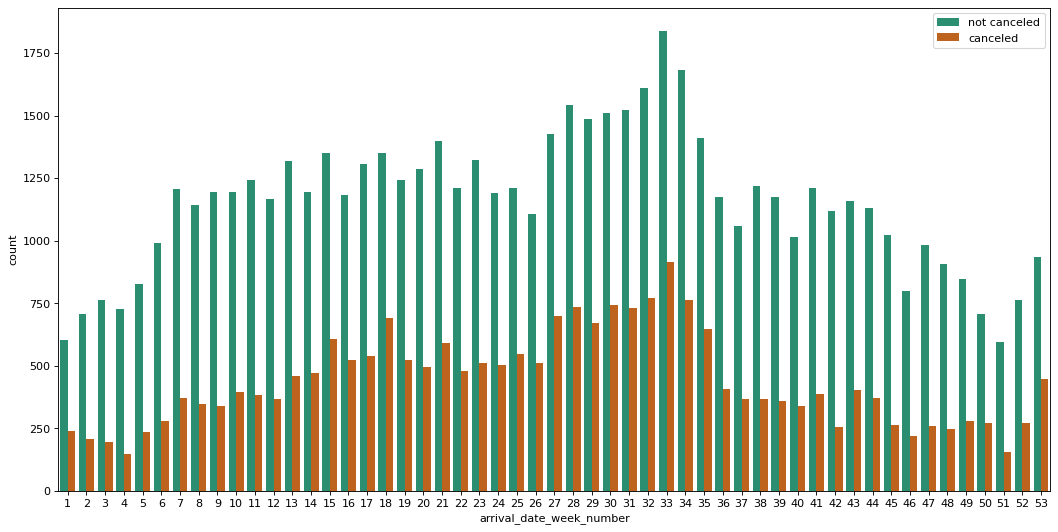

In [ ]:
# Look at arrivals by week number
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(data = d_clean, x = 'arrival_date_week_number',
hue = 'is_canceled',palette='Dark2',ax=ax)

plt.legend(["not canceled", "canceled"])
plt.show()

## Model Fitting and Tuning

In order to create a Machine Learning Model we have to first decide what our inputs and outputs will be. Since the `is_canceled` variable is the one we care about, we use it as our output `Y` and all of the rest columns of our dataset we use as our inputs `X`. We also split the data into a testing and training set, using  the `train_test_split` from the `model_selection` submodule of `scikit-learn`. We chose a test size of 10% since we have a very large dataset.

In [ ]:
X = d_clean.drop('is_canceled', axis=1)
Y = d_clean['is_canceled']

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.1)

### Baseline Model - Logistic Regression

Firstly, we define our baseline model, which is a Logistic Regression one in order to compare it with our final model. Logistic regression is a discriminative classifier that can be seen a simple generalization of linear regression by making two changes. The first change is that instead of a Gaussian Distribution we use a Bernoulli distribution for the output $y$, and the second is that we pass the linear function of the inputs through a link function which outputs a binary result.

The Logistic Regression model was fit using the `LogisticRegression` model function from the `linear_model` submodule of sklearn. Although the accuracy score was reasonable (76%), the distribution of TP, FP, TN and FN was distributed evenly, and any kind of tuning (including a adding a penalty term, increasing maximum iterations etc.) did not solve this issue. After having a baseline model, we continued on exploring a model which was more appropriate for our dataset.

In [ ]:
m = LogisticRegression(penalty='none', fit_intercept = False, 
solver='lbfgs', max_iter=5000).fit(x_train, y_train)

yhat = m.predict(x_test)

print(accuracy_score(yhat, y_test))
confusion_matrix(yhat, y_test)

0.7599905414991723


array([[5601, 1561],
       [ 469,  827]])

### Random Forest Model

When choosing what model to use to predict whether a particular reservation will be cancelled or not, it was important that the model be highly accurate as not to lead to missed income. Hence, when the different models were fitted the accuracy score was the testing metric of highest interest. The accuracy metric directly measures the ratio of how many correct classifications made in the testing data, to total number of predictions made.  As a result of this it was discovered that the random forest model seemed most suitable to this use case (reasons why the other models were worse will be discussed below). 

This method is based on decision trees, which follow a simple set of steps: beginning at a ‘parent node’, a feature is chosen in order to split the sample and provide the largest possible information gain – there is no split if there is no gain found for any feature. This is then repeated for the two 'child nodes', continuing until all of the samples at a node are in the same classification, or a criterion has been met - for example a maximum number of splits has occurred. 

A random forest is an extension of this algorithm through a technique called bagging, whereby a base classifier (in this case, the decision tree) is repeatedly trained on bootstrapped samples from the dataset, with the predictions averaged to produce the result. This produces an ensemble of classifiers, which in this model are decorrelated by using a random sample of features for each split in a tree – otherwise the optimal information gain at the first node will likely be the same each time, leading to a lack of exploration of other possible splits. The exact number of features to consider at a node is a tuneable hyperparameter, with the common starting point of around $\sqrt{(n)}$ or $\log_2(n)$, for data containing $n$ features. 

A short summary of the algorithm is as follows:

* Produce a bootstrap sample 
* Create a decision tree for this sample, selecting the best feature for splitting at each node, from a random set of features which have been chosen without replacement
* Once all trees have finished, form a prediction by averaging the probabilistic predictions of each one.

The Random Forest Model function we use is called `RandomForestClassifier`, available from `sklearn`. One of the most important parameters we defined for this function was the `class_weight`. In our data, we have fewer cancellations than non-cancellations, which means that there will be a bias towards classifying the majority class - a standard issue with random forest classifiers. In order to combat this, there are a couple of options for the `class_weight` parameter. The first is to use `balanced` weights, which makes the weighting inversely proportional to the size of the class, thus focusing on the minority class. We have opted for a similar parameter, called `balanced_subsample`, which produces the same inverse weighting system but based on the bootstrapped sample for each tree, as opposed to the whole population. This means that even if the samples contains different proportions of cancellations, the weighting will be consistent and reflect each sample.

In order to find the best parameters for our Random Forrest Model we use the `RandomizedSearchCV` function from `sklearn` to search through some hyperparameters and find the model which produces the highest prediction accuracy score. For now, we search through the number of possible trees in a random forrest (`n_estimators`) and the minimum number of samples requred to split a node (`min_samples_split`). We have also checked some other hyperparameters like `max_depth` and `max_features` but we have the decided that the default values were the best after running some models. 

Within the `RandomizedSearchCV` function we are also using cross validation. Cross validation is a method in which resampling is used to evaluate the model. The procedure only has one parameter `k` which lets the procedure know into how many groups the data should be split. In this application we set `k = 5` which splits our training dataset into 4 folds for training the model and one-fold for validating the results which have been provided by the training. Splitting the data into these folds then provides a general indication of the skill of the model when it is given unfamiliar data (data not used in the training). This method of splitting the data is a popular one because it generally results in a less optimistic or more reliable estimate of the skill of the model.

In [ ]:
## Hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(500, 700, 5)]

# Minimmum number of samples required to split a node
min_samples_split = [2, 5, 7]

# Create the dictionary to be used in grid or random searches
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
}

In [ ]:
rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [ ]:
rf_random = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=random_grid, 
    scoring='accuracy',
    cv=KFold(5, shuffle=True, random_state=42),
    verbose=0, 
    n_jobs=1
    ).fit(x_train, y_train)

In the cell below we see what the best parameters were out of this Randomized Search and the best score out of the validating set:

In [ ]:
rf_random.best_params_

{'n_estimators': 550, 'min_samples_split': 5}

In [ ]:
rf_random.best_score_

0.8484398607370427

As our outcome variable is binary, we use metrics that measure our classifier's ability to correctly label our data using the following possible outcomes for each prediction:

* *true positives* (TP) - labeled as cancelled when it is cancelled 
* *false positives* (FP) - labeled as cancelled when it is not cancelled
* *true negatives* (TN) - labeled as not cancelled when it is not cancelled
* *false negatives* (FN) - labeled as not cancelled when it is cancelled

The `predict` function chooses these labels based on whichever probability is larger, in the binary case this is equivalent to asking if the probability of a booking getting canceled is $\geq 0.5$ for each observation. The results are then presented in a confusion matrix (TN on the top left, FP on the top right, FN on the bottom left and TN on the bottom right) which is then also used to calculate the `accuracy score` which is defined as 1 - Test Error rate:

 $$ 1 - \frac{1}{N^{*}} \sum_{n=1}^{N^{*}} \mathbb{I}\left(y_{n}^{*} \neq \widehat{y}\right)  $$

where $N^{*}$ are the total number of testing samples, $y_{n}^{*}$ the output from the testing set and $\widehat{y}$ the predicted output of the model.

In [ ]:
rf_pred = rf_random.predict(x_test)

print('Model: Random Forest\n')
print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,rf_pred), confusion_matrix(y_test,rf_pred)))

Model: Random Forest

Accuracy Score: 0.8525656183494916

Confusion Matrix:
 [[5483  587]
 [ 660 1728]]


### Final Model

After our tuning through `RandomizedSearchCV` we get the best predicted parameters (`n_estimators` = 700, `min_samples_split` = 5) and use them to create the `alg_model` which is our final model. We retrain the data and predict the outcomes again using the predict attribute of `RandomForestClassifier`.  

In [ ]:
alg = RandomForestClassifier(class_weight='balanced_subsample', 
                             random_state=42,
                             n_estimators = 550,
                             min_samples_split = 5)
alg_model = alg.fit(x_train, y_train)

y_prob = alg.predict_proba(x_test)[:,1]
y_pred = alg_model.predict(x_test)

print('Model: Random Forest\n')
print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))

Model: Random Forest

Accuracy Score: 0.8525656183494916

Confusion Matrix:
 [[5483  587]
 [ 660 1728]]


Now, the random forest model used above assigns a different importance to each feature depending on their `gini importance`. This importance value is defined by sklearn as the total decrease in node impurity averaged over all trees in a random forest ensemble. Hence, it is possible to see which features have highest impact on the final categorical prediction. This information could be useful to the hotel administration as it shows which features they should keep an eye on.

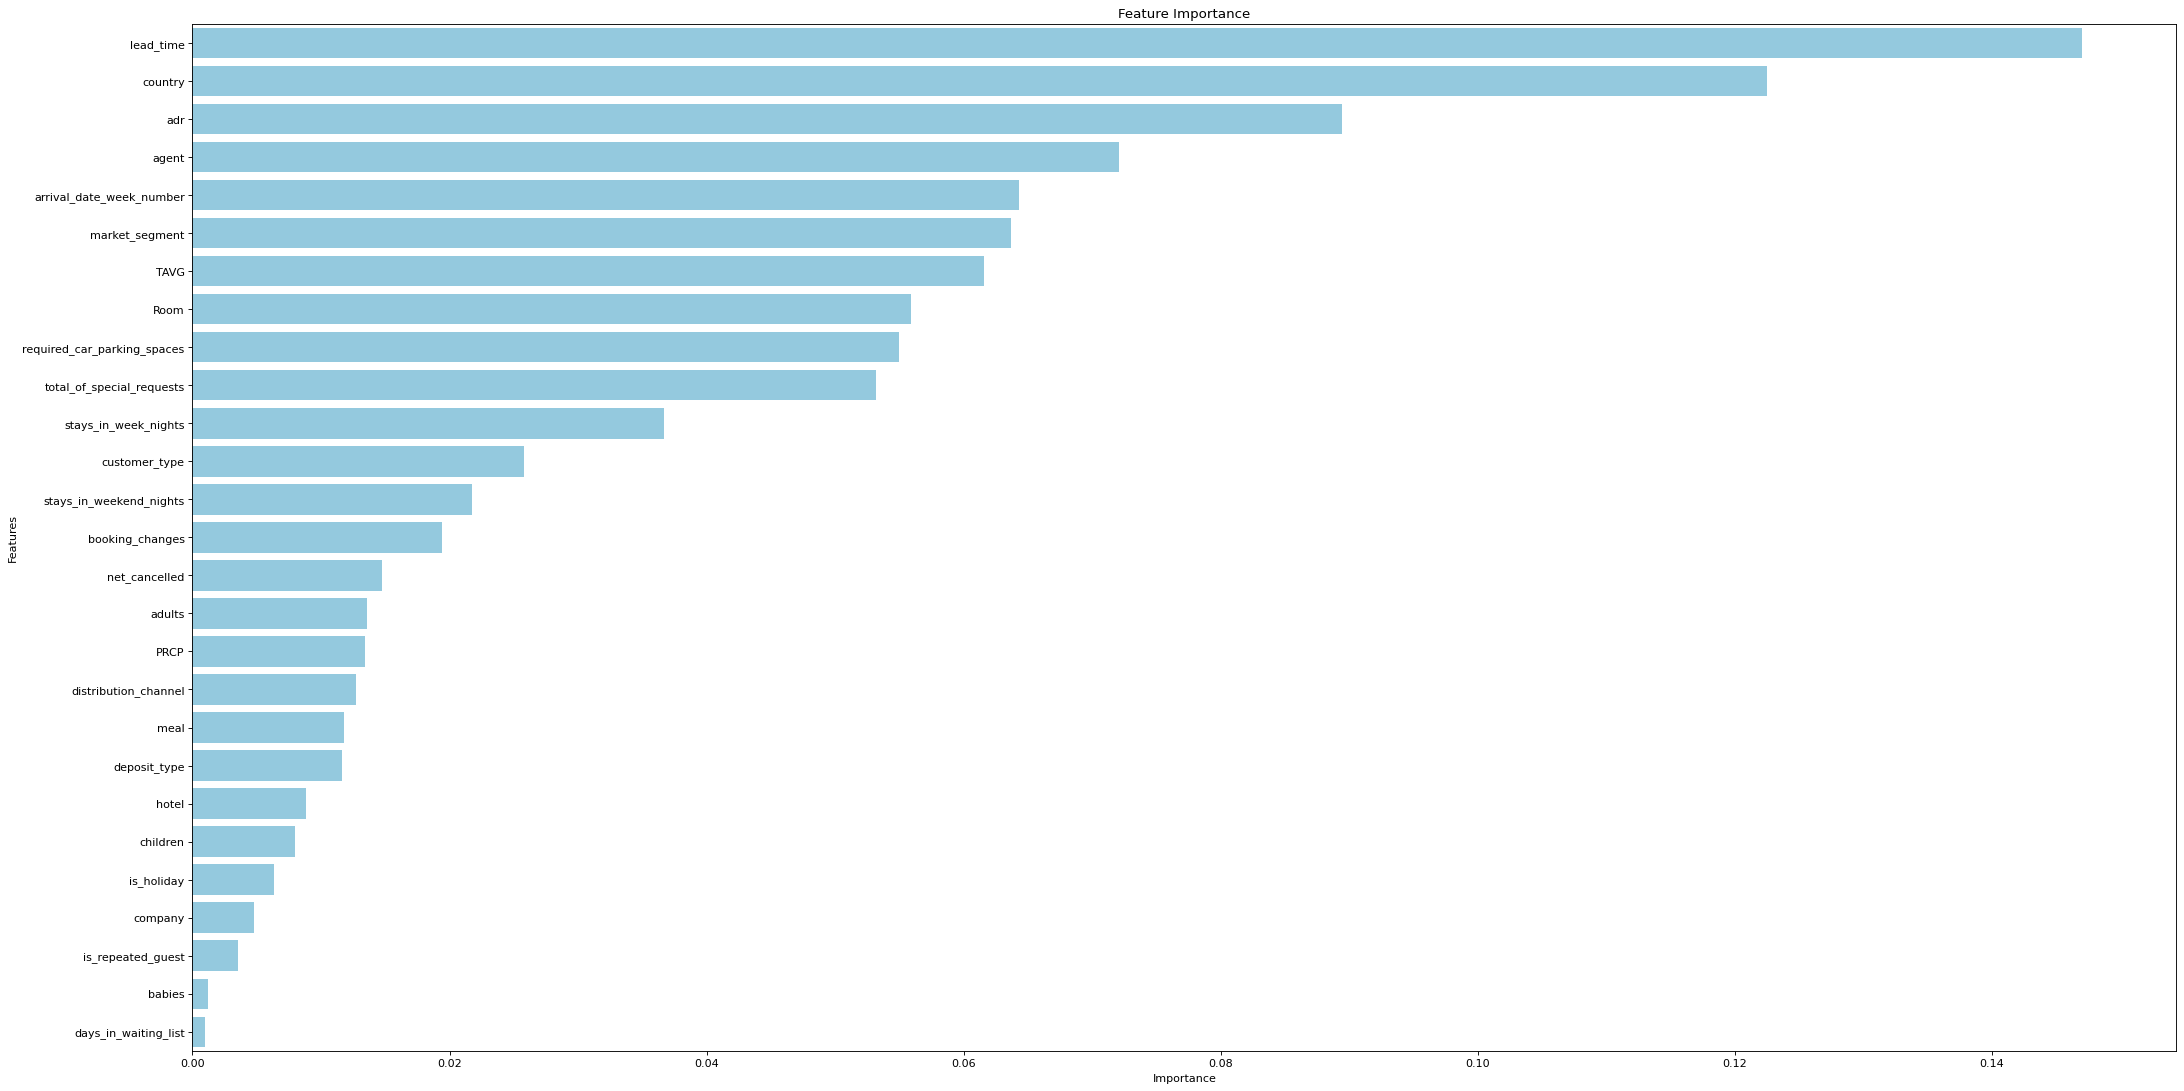

None

In [ ]:
# This plots the importance of each feature in the model
features = {}
for feature, importance in zip(x_train.columns, alg.feature_importances_):
    features[feature] = importance
importances = pd.DataFrame.from_dict(features, 
orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
# sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig, ax = plt.subplots()
fig.set_size_inches(32,17)
sns.barplot(x=importances['Gini-Importance'], 
y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
display(plt.show())

Another method of visualising the results of our model is to generate a Receiver Operating Characteristic (ROC) curve for the model which plots the true positive rate against the false positive rate. The `roc_curve` function returns a tuple of the false positive rate, true positive rate, and threshold values based on the true labels and the predicted probabilities.  The 0-1 line is the ROC curve expected for a model that determines labels by chance.

A very insightful summary statistic that is used to summarize the performance of a binary classifier over all the possible thresholds is the area under the curve (AUC), which is the area under the ROC curve. This can be calculated from the prediction results using the `roc_auc_score` function  from the `sklearn.metrics` submodule.

In [ ]:
def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', 
    label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

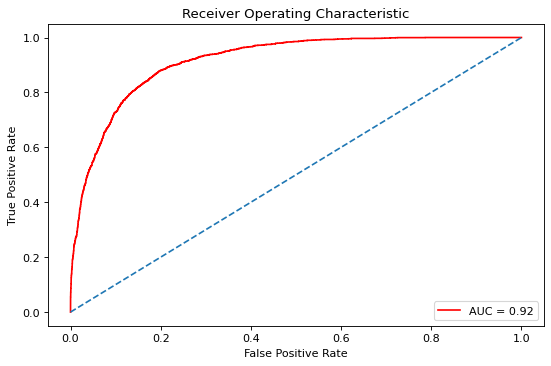

In [ ]:
ROC(y_test, y_prob)

### Other models considered

In our attempt to create the best model possible we considered different kinds of models.


Alongside the baseline logistic regression model, one of the other models that we looked at was a Support Vector Machine (SVM), with the `SVC` function. The reason that we did not choose to pursue this model is that from the initial tests, the time taken to run each fit and evaluation was too long, as well as lower accuracy (75%) than given by other models with far quicker computation time. This makes sense, since the time complexity is between $O(n _ {obs}^2 \cdot n _{fea})$ and $O(n _ {obs}^3 \cdot n _{fea})$ for SVMs, compared to, for example, $O(n_ {obs} \log(n_ {obs}) \cdot n _{fea})$ for a decision tree, and we have a lot of observations, so for large $n_ {obs}$, SVMs will be much slower. In order to combat this, we did attempt to use the `LinearSVC` function which is designed to handle large datasets better, and while it did do the fitting significantly quicker, the accuracy was not good enough - 71%.

Another model that was fitted to the data was a simple decision tree. The decision tree functions a lot like the random forest model, this is because the decision forest is basically just an ensemble of decision trees. Hence, as expected the decision tree obtained a lower accuracy score at 0.79 than the random forest model.


##  Discussion & Conclusions


Our analysis has showed that the random forest with the default parameters (except of `n_estimators` and `min_samples_split` ) already has a high accuracy score. However, naturally, the question of tuning further hyperparameters of the model arose. This process began with looking into feature importance/selection. This was done using the sklearn principal component analysis submodule. This allowed for calculations of the cumulative explained variance in the decisions taken by the random forest. This provided the insight that using more than the top 5 gini-important features in the data provides no extra variance in the result. However, when using just these 5 features the random forest actually resulted in a somewhat less accurate model. Hence, to create the most accurate model all features were included. Our model ended up with an accuracy of around 85%, which means that the correct classification occured this often. This is fairly reliable, but we discuss below adaptations that can be made in order to improve the model for the requirements of the hotel.

### Economic viability



If we would like to extend our model for our client and allow it to be used commercially, to give an insight to the hotel staff about overbooking a particular room, we would need to define a specific loss function depending on the revenue of each booking. 

Specifically, we need to have some numeric measure of the benefit for true positives and true negatives and the costs of false negatives and false positives, depending on the total revenue of the booking. It is very difficult to quantitatively determine what this loss function should be, but a further insight into the revenue from each booking would allow us to find a reasonable loss function and extend our model.

For example, when we tested our model in Section 3, we found 587 false positives. This means that the hotel would be told that these bookings would be cancelled, so the room should be opened up for the option of rebooking, however the customer then doesn't cancel and still turns up. This is a False Discovery Rate (FDR) of 25% in our testing data, which means we should expect every 100 bookings that are predicted to be cancelled to result in 25 double booking issues. 

However, we also have a portion of false negatives - 660 in our sample, giving a False Omission Rate (FNR) of just under 11%. Similarly to above, in context, this means that around 10 or 11 out of every 100 bookings are predicted as arriving normally, only for them then to be cancelled. On these occasions, there would be no conflict from people needing the same room - but the room would be empty, with a loss of revenue for the hotel. 

It is these rates that need to be weighed up to allow the hotel to balance loss of revenue on FNs vs double bookings with FPs. Currently, we have FPs occuring over twice as often as FNs, which means that if an empty room costs twice as much as a double booking, then the losses are balanced. If we want to adjust the model to reduce one rate - for example, reduce FOR as empty rooms are too costly - we will necessarily encounter more of the other - the algorithm will avoid negative classifications to reduce FOR, which will boost FDR. This kind of adjustment can be made in the model through a range of ways. For example:

* Changing the `class_weight` hyperparameter to favour one classification, and reduce the rate of the other. 

* In order to reduce FDR, we can monitor the precision during cross validation, in order to find the highest precision. This will lead to very low FDR, as precision approaches 1, because they are complementary metrics; however, this will likely lead to worse recall, as can be seen from the plot below. 

In order to finalise any adjustments to the model, along these lines, we would need the revenue and priorities mentioned above. 

Definitions of metrics:

* Precision: $\frac{TP}{TP + FP}$
* Recall: $\frac{TP}{TP + FN}$
* FDR: $\frac{FP}{TP + FP}$
* FOR: $\frac{FN}{TN + FN}$

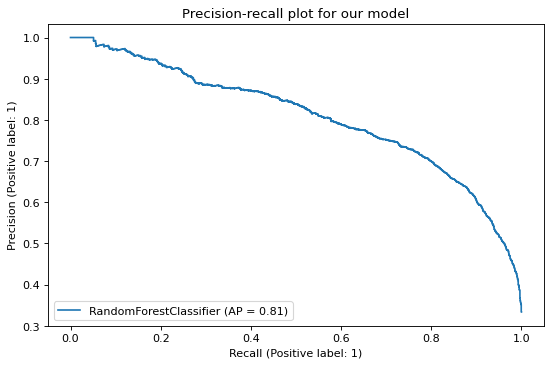

In [ ]:
fig, ax = plt.subplots()
plot_precision_recall_curve(alg,x_test,y_test,ax=ax)
plt.title('Precision-recall plot for our model')
plt.show()

### Usage


The result of all of the above is a model that has been trained by a large amount of data and shown to be quite accurate (when testing on the test data). This thus provided a hotel or chain of hotels to input a reservation into the model and be told whether the model predicts the room will cancel or not - weather details can be provided with a long term forecast, or historic data for that day of the year. This has as obvious advantage that a hotel can then double book a room they predict will be cancelled as to not miss out on customers when the hotel is fully booked. Following is an example of a new reservation and whether the model predicts whether this booking will be cancelled or not. In this case we take a random entry from the testing data set and predict what the cancellation status will be:

In [ ]:
# Pick random data entry from the testing data
d_trial = x_test.sample()

Hence, now that this reservation data point has been entered into the system of the hotel, the hotel can use the alg model created to predict whether the reservation will be cancelled or not:

In [ ]:
print(f'Predicted cancellation status: {alg.predict(d_trial)[0]}')

Predicted cancellation status: 0


The model predicts that this reservation will not be cancelled and thus informs the hotel that the room assigned to this reservation should not be double booked.

### Conclusion

To conclude, we have produced a model that can predict whether a booking will be cancelled with over 85% accuracy, based on a dataset from Antonio, Almeida and Nunes, 2019 on hotel bookings. It utilises a random forest algorithm that takes the values for a wide range of features stored in the hotels' PMS databases, as well as weather data such as rainfall and temperature, and produces a prediction as to whether or not the customer is likely to cancel. There is scope for the model to be used by the hotel, with the potential to extend it to match their priorities in terms of lost revenue for empty rooms, and capacity to handle conflicts arising from double booked rooms. 

Our model should have a positive effect on the revenue of the hotel if there is currently no predictive method in place, especially if it is adjusted. The hotel should only not implement the method if they want to completely avoid double bookings at all costs - these would happen sometimes with our model, although obviously offset by the benefit of true predictions. Otherwise, there will be some sort of loss function which can find the ideal balance for the hotel, with a small enough number of false positive or negative predictions, while also profitting from correct predictions that result in more rooms being rebooked, and fewer going empty.

In [2]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf MLP2_final.ipynb

[NbConvertApp] Converting notebook MLP2_final.ipynb to pdf
[NbConvertApp] Support files will be in MLP2_final_files/
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Making directory ./MLP2_final_files
[NbConvertApp] Writing 96683 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=63a8c849-8822-46a5-9dc9-c4891253981f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>